t: 0.0, survival_probability: 1.0
t: 0.05, survival_probability: 0.9996870144968485
t: 0.1, survival_probability: 0.9987499117045261
t: 0.15000000000000002, survival_probability: 0.9971627395831829
t: 0.2, survival_probability: 0.9949809145186638
t: 0.25, survival_probability: 0.9922277543212098
t: 0.30000000000000004, survival_probability: 0.9888295981258335
t: 0.35000000000000003, survival_probability: 0.9848101539990142
t: 0.4, survival_probability: 0.9801413234915913
t: 0.45, survival_probability: 0.9750261374115631
t: 0.5, survival_probability: 0.9692852730174105
t: 0.55, survival_probability: 0.9630040012972118
t: 0.6000000000000001, survival_probability: 0.9560141218122407
t: 0.65, survival_probability: 0.9484478338632363
t: 0.7000000000000001, survival_probability: 0.9405593893894793
t: 0.75, survival_probability: 0.932177661030456
t: 0.8, survival_probability: 0.9231365947567514
t: 0.8500000000000001, survival_probability: 0.9135265348875418
t: 0.9, survival_probability: 0.903

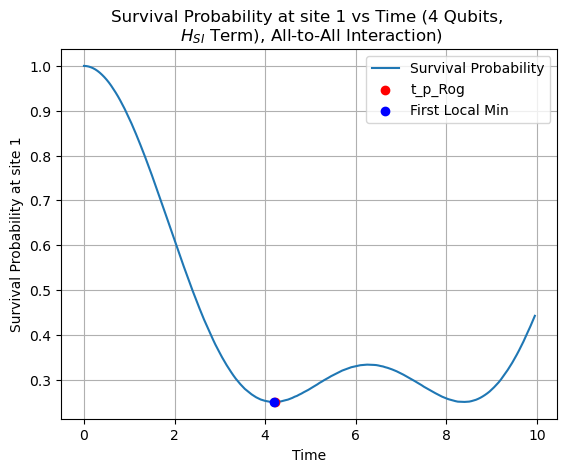

In [5]:
# main_self_int script 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
import sys
import os


# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit

def initialize_parameters():
    N_sites = 4  # Number of qubits
    delta_m_squared = 0
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    B = [1, 0, 0]
    shots = 10249676
    backend = AerSimulator(method='automatic')
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, ttotal, τ) 
    mu = 1.0
    interaction_strength = mu / (2 * N_sites)

    return N_sites, mu, omega, B, interaction_strength, shots, backend, tolerance, τ, times


def simulate(times, omega, N_sites, H, backend, shots, τ, tolerance):
    # Simulation and expected value calculation
    sigma_z_values = []
    survival_probabilities = []

    for t in times:
        qc = evolve_and_measure_circuit(t, H, N_sites)
        result = backend.run(qc, shots=shots).result()    
        counts = result.get_counts(qc)
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        
        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)


    def find_first_local_minima_index(arr):
        n = len(arr)
        for i in range(1, n - 1):
            if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
                return i
        return -1

    # Index of the first minimum of the survival probabilities
    i_first_local_min = find_first_local_minima_index(survival_probabilities)

    # Writing if_else statement to communicate if local minima (not) found
    if i_first_local_min != -1:
        print(f"Index of the first local minimum: {i_first_local_min}")
    else:
        print("No local minimum found in the array.")
        
        
    # Time at which the first minimum survival probability is reached
    t_min = τ * i_first_local_min
    print(f"Corresponding time of first minimum index= {t_min}")

    # Calculate Rogerro's fit for the first minimum of the survival probability
    a_t = 0
    b_t = 2.105
    c_t = 0

    t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
    print("t_p_Rog= ", t_p_Rog)

    # Assert condition
    assert abs(t_min - t_p_Rog) < τ + tolerance, "The time of the first minimum survival probability is not within the expected range."

    return sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min


def plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min):
    # Plot the survival probability at site 1 against time
    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $H_{{SI}}$ Term), All-to-All Interaction)')

    # Add scatter point for Rogerro's fit
    plt.scatter([t_p_Rog], [survival_probabilities[np.abs(times - t_p_Rog).argmin()]], color='red', label="t_p_Rog", zorder=5)

    # Add scatter point for the first local minimum
    if i_first_local_min != -1:
        plt.scatter([t_min], [survival_probabilities[np.abs(times - t_min).argmin()]], color='blue', label="First Local Min", zorder=5)

    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
def main():
    N_sites, mu, omega, B, interaction_strength, shots, backend, tolerance, τ, times = initialize_parameters()
    H = construct_hamiltonian(N_sites, interaction_strength, omega, B)
    sigma_z_values, survival_probabilities, t_min, t_p_Rog, i_first_local_min = simulate(times, omega, N_sites, H, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, survival_probabilities, N_sites, t_min, t_p_Rog, i_first_local_min)

if __name__ == "__main__":
    main()